#### Basics

In [1]:
# make the figures that might be used in fig 2: effects of res fluc to surv strat
import itertools
import numpy as np
from random import choice
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns
from collections import defaultdict
import pickle

from lag_test_utils_leaky_mod import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
from colorsys import rgb_to_hls, hls_to_rgb
import seaborn as sns

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

In [2]:
def get_shannon_index(sample):
    info = [[], [], []]
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            if(spc.id==name and spc.cat=="Seq"):
                info[0].append(spc.phi)
                info[1].append(spc.pref[0])
            elif(spc.id==name and spc.cat=="Cout"):
                info[0].append(spc.phi)
                info[1].append(1)
        info[2].append(sample[1]["bs"][-1][idx])
    phis, prefs, bs = info
    sum_dict = defaultdict(float)
    for phi, pref, b in zip(phis, prefs, bs):
        sum_dict[(phi, pref)] += b
    abundances = list(sum_dict.values())
    proportions = np.array(abundances) / sum(abundances)
    return np.exp(-sum(p * np.log(p) for p in proportions if p > 0))

# Define soft colors
soft_red = '#f61010'
soft_blue = '#0000ff'
soft_blue1 = '#5555ff'
soft_purple = "#B39DEB"
soft_green = '#58C358'
brown = "#deaa87"
yellow = "#ffd42a"
colors_list = [(0.0, soft_blue),    # -4 (maps to 0.0 in normalized space)
               (1+log10(0.01)/4, soft_blue1), # -2 (maps to 0.5)
               (1+log10(0.1)/4, soft_purple),     # -1 (maps to 0.75)
               (1.0, soft_red)]     # 0 (maps to 1.0 in normalized space)
cmap_rb = mcolors.LinearSegmentedColormap.from_list('custom_rb', colors_list)
green_cmap = mcolors.ListedColormap([soft_green])

# or just use grayscale
colors_list = [(0.0, "w"),    # -4 (maps to 0.0 in normalized space)
            #    (1+log10(0.01)/4, soft_blue1), # -2 (maps to 0.5)
               (1+log10(0.1)/4, "gray"),     # -1 (maps to 0.75)
               (1.0, "k")]     # 0 (maps to 1.0 in normalized space)
cmap_gray = mcolors.LinearSegmentedColormap.from_list('custom_rb', colors_list)

# define phase diagram colors
# Create the colormap
soft_red2 = '#C35858'
soft_blue2 = '#5858C3'
cmap_phase = ListedColormap([soft_green, soft_blue2, soft_red2])

def get_frac_b1(sample):
    abund_b1, abund_b2 = 0, 0
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            if(spc.id==name):
                if(spc.pref==(1, 2)):
                    abund_b1 += sample[1]["bs"][-1][idx]
                else:
                    abund_b2 += sample[1]["bs"][-1][idx]
    return abund_b1, abund_b2
                
def get_phi(sample, strat):
    thres = -1
    pairs = []
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            nR = len(spc.g)
            if(spc.id==name and strat in spc.id and spc.phi>thres):
                if(spc.phi==0.0001):
                    pairs.append((MIN_PHI, sample[1]["bs"][-1][idx]))
                else:
                    pairs.append((spc.phi, sample[1]["bs"][-1][idx]))
    return pairs

In [3]:
def make_hist(pairs, nbins, ax, nR=2, factor=False):
    # main text case has a factor difference in definition from later simulated data
    if(factor):
        factor=nR/(nR-1)
    else:
        factor = 1
    a1_values = np.array([max(-3, np.log10(pair[0]*factor)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo, xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
    ax.set_xlim(-3.4, 0.1)
    ax.set_xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
    ax.set_yticks([])
    ax.axvline(-4, color="k", linestyle="-.")
    ax.set_xlabel("$\\phi$")
    ax.set_ylabel("Histogram")

#### Effects of dilution factor D

In [18]:
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
tau0, p= 0.3, 0.5
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
Dlist = [10, 100.0, 1000, 10000]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


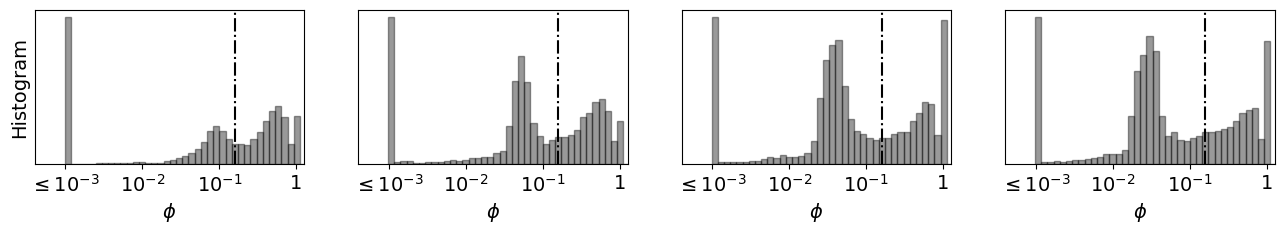

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(16, 2), sharex=True, sharey=False)
for idx_D in tqdm(range(len(Dlist))):
    D = Dlist[idx_D]
    all_pairs = []
    for a in alphas:
        for q in qs:
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
    ax = axes[idx_D]
    if(D==100):
        factor_use = True
    else:
        factor_use = False
    make_hist(all_pairs, 50, ax, nR, factor_use)
    ax.axvline(-0.8, color="k", linestyle="-.")
    if(idx_D>0):
        ax.set_ylabel("")
# plt.savefig(f"figs/supp/D_hist.pdf", bbox_inches="tight")

0it [00:00, ?it/s]

10it [00:01,  5.47it/s]


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (5).

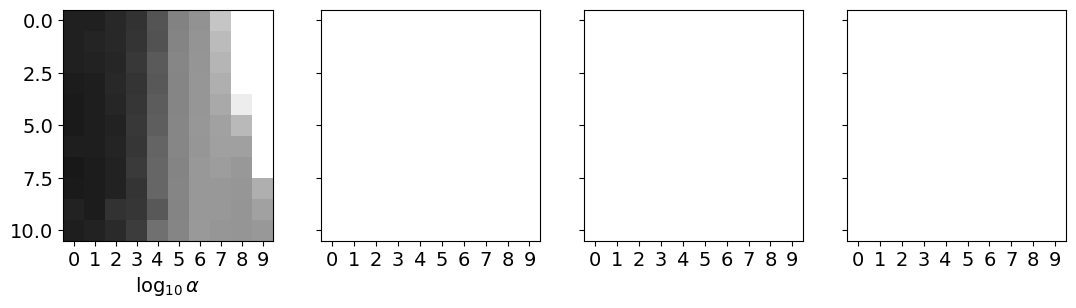

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(13, 3), sharex=True, sharey=True)
for idx_D in range(len(Dlist)):
    D = Dlist[idx_D]
    if(D==100):
        factor = nR/(nR-1)
    else:
        factor = 1
    avr_log_phis = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
            elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(factor)
            # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
            surv_list = []
            for sample in data:
                surv_list.extend(sample[0])
            avr_log_phis[idx, jdx] = elem

    data = avr_log_phis.T
    norm = mcolors.Normalize(vmin=-3, vmax=0)
    ax = axes[idx_D]
    im = ax.imshow(data, cmap=cmap_gray, norm=norm)
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-2], rotation=45)
    if(idx_D==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_ticks([0, -1, -2, -3])
cbar.set_ticklabels(["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"][::-1])
plt.savefig(f"figs/supp/D_phase.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

10it [00:02,  4.59it/s]
10it [00:02,  4.74it/s]
10it [00:01,  5.20it/s]
10it [00:01,  5.12it/s]


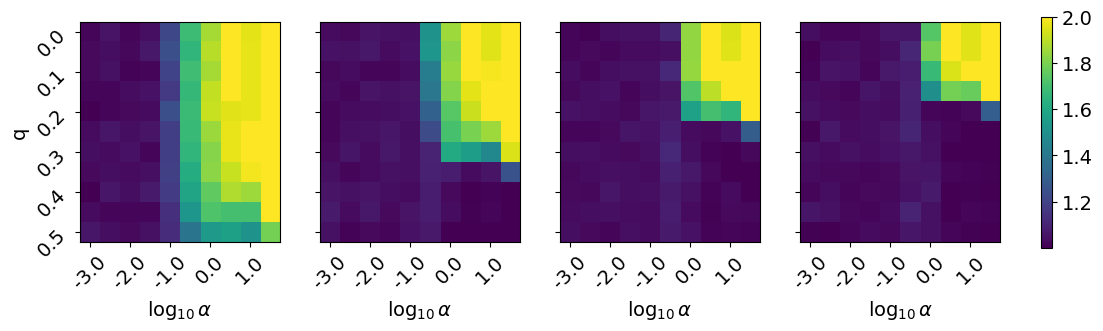

In [53]:
fig, axes = plt.subplots(1, 4, figsize=(13, 3), sharex=True, sharey=True)
for idx_D in range(len(Dlist)):
    alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
    tau0, p= 0.3, 0.5
    D = Dlist[idx_D]
    qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
    shannon_diversity = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            shannon_diversity[idx, jdx] = min(nR, np.mean([get_shannon_index(i) for i in data]))
    data = shannon_diversity.T
    ax = axes[idx_D]
    im = ax.imshow(data, cmap="viridis")
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::2], rotation=45)
    if(idx_D==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.savefig(f"figs/supp/D_div.pdf", bbox_inches="tight")
plt.show()

#### Effects of p ("smartness" of the species )

In [54]:
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
tau0, D = 0.3, 100
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
plist = [0.3, 0.5, 0.7]

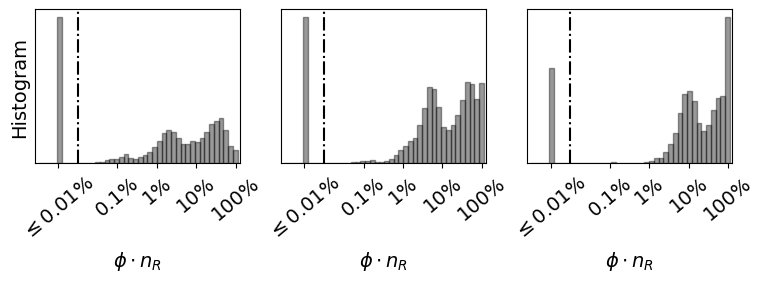

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2), sharex=True, sharey=False)
for idx_p in range(len(plist)):
    p = plist[idx_p]
    all_pairs = []
    for a in alphas:
        for q in qs:
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
    ax = axes[idx_p]
    make_hist(all_pairs, 50, ax, nR)
    if(idx_p>0):
        ax.set_ylabel("")
plt.savefig(f"figs/supp/p_hist.pdf", bbox_inches="tight")

10it [00:01,  6.10it/s]
10it [00:01,  6.12it/s]
10it [00:01,  6.48it/s]


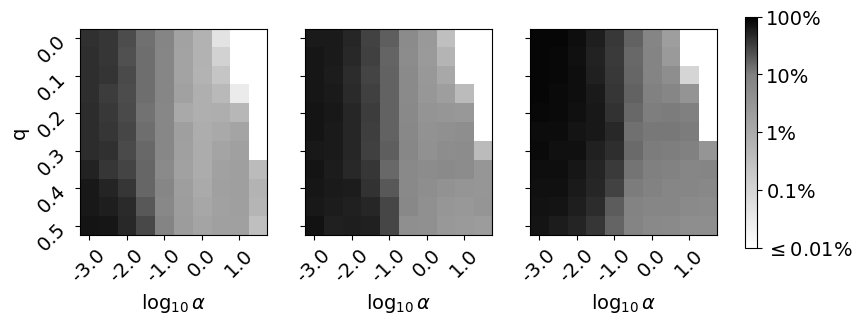

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
for idx_p in range(len(plist)):
    p = plist[idx_p]
    avr_log_phis = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
            elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(nR)
            # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
            surv_list = []
            for sample in data:
                surv_list.extend(sample[0])
            avr_log_phis[idx, jdx] = elem

    data = avr_log_phis.T
    norm = mcolors.Normalize(vmin=-4, vmax=0)
    ax = axes[idx_p]
    im = ax.imshow(data, cmap=cmap_gray, norm=norm)
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::2], rotation=45)
    if(idx_p==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_ticks([0, -1, -2, -3, -4])
cbar.set_ticklabels(["100%", "10%", "1%", "0.1%", "$\\leq$0.01%"])
plt.savefig(f"figs/supp/p_phase.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

10it [00:02,  4.72it/s]
10it [00:02,  4.76it/s]
10it [00:01,  5.12it/s]


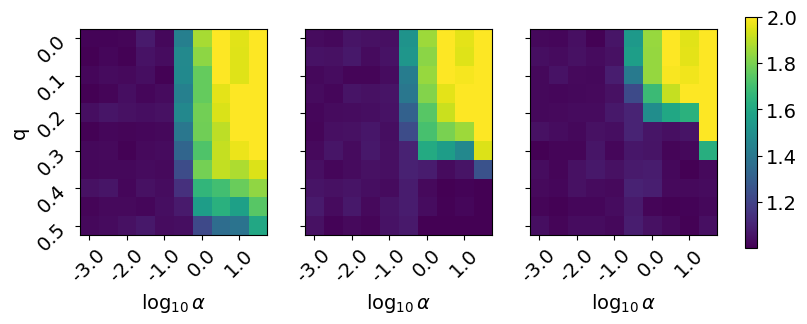

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
for idx_p in range(len(plist)):
    p = plist[idx_p]
    alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
    tau0, D= 0.3, 100
    qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
    shannon_diversity = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            shannon_diversity[idx, jdx] = min(nR, np.mean([get_shannon_index(i) for i in data]))
    data = shannon_diversity.T
    ax = axes[idx_p]
    im = ax.imshow(data, cmap="viridis")
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::2], rotation=45)
    if(idx_p==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.savefig(f"figs/supp/p_div.pdf", bbox_inches="tight")
plt.show()

#### Effects of lag coefficient $\tau_0$

In [58]:
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
p, D = 0.5, 100
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
tau_list = list(np.round(np.linspace(0.1, 1.1, 6), 2))

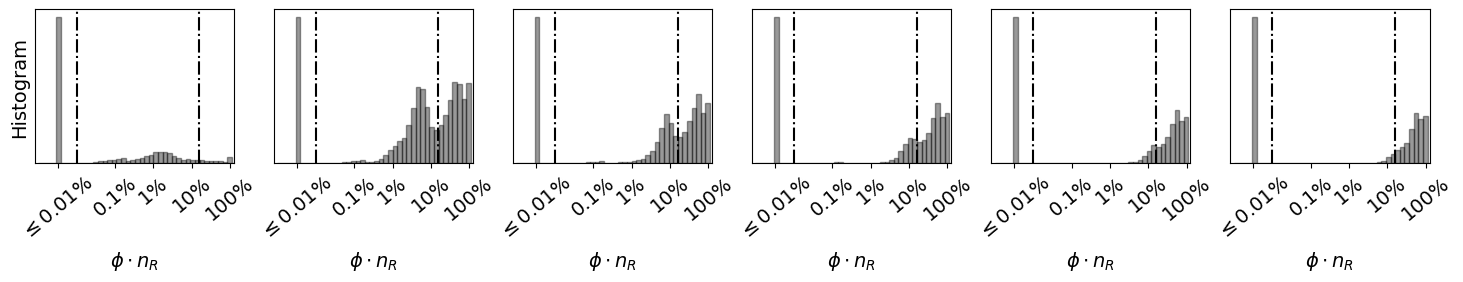

In [59]:
fig, axes = plt.subplots(1, 6, figsize=(18, 2), sharex=True, sharey=False)
for idx_t in range(len(tau_list)):
    tau0 = tau_list[idx_t]
    all_pairs = []
    for a in alphas:
        for q in qs:
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
    ax = axes[idx_t]
    make_hist(all_pairs, 50, ax, nR)
    ax.axvline(-0.8, color="k", linestyle="-.")
    if(idx_t>0):
        ax.set_ylabel("")
plt.savefig(f"figs/supp/t_hist.pdf", bbox_inches="tight")

0it [00:00, ?it/s]

10it [00:01,  6.03it/s]
10it [00:01,  6.13it/s]
10it [00:01,  6.33it/s]
10it [00:01,  6.42it/s]
10it [00:01,  6.47it/s]
10it [00:01,  6.89it/s]


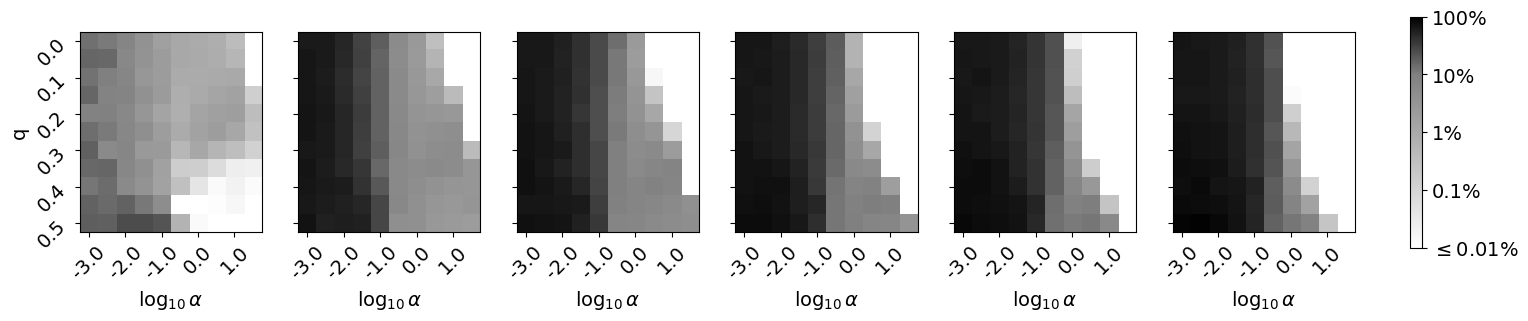

In [60]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
for idx_t in range(len(tau_list)):
    tau0 = tau_list[idx_t]
    avr_log_phis = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
            elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(nR)
            # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
            surv_list = []
            for sample in data:
                surv_list.extend(sample[0])
            avr_log_phis[idx, jdx] = elem

    data = avr_log_phis.T
    norm = mcolors.Normalize(vmin=-4, vmax=0)
    ax = axes[idx_t]
    im = ax.imshow(data, cmap=cmap_gray, norm=norm)
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::2], rotation=45)
    if(idx_t==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_ticks([0, -1, -2, -3, -4])
cbar.set_ticklabels(["100%", "10%", "1%", "0.1%", "$\\leq$0.01%"])
plt.savefig(f"figs/supp/t_phase.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

10it [00:02,  4.68it/s]
10it [00:02,  4.85it/s]
10it [00:02,  4.79it/s]
10it [00:02,  4.86it/s]
10it [00:02,  4.90it/s]
10it [00:02,  4.93it/s]


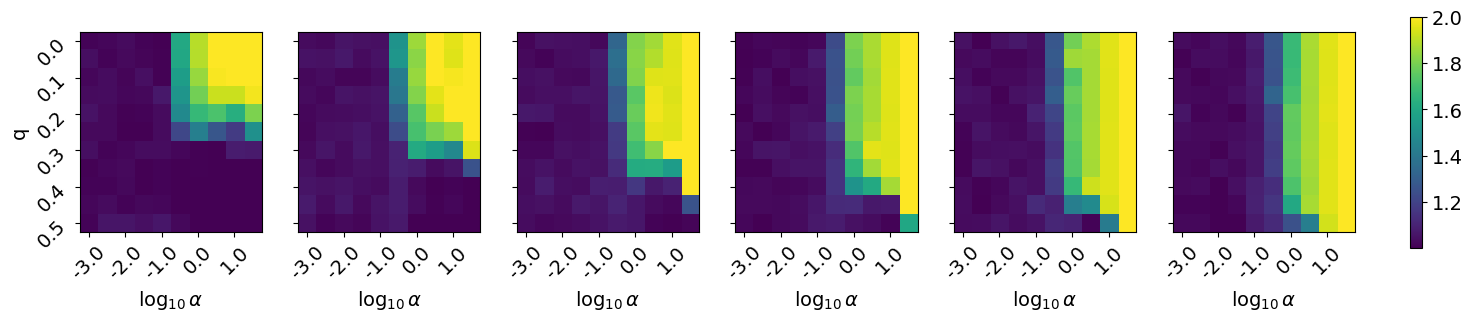

In [61]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
for idx_t in range(len(tau_list)):
    tau0 = tau_list[idx_t]
    alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
    qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
    shannon_diversity = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            shannon_diversity[idx, jdx] = min(nR, np.mean([get_shannon_index(i) for i in data]))
    data = shannon_diversity.T
    ax = axes[idx_t]
    im = ax.imshow(data, cmap="viridis")
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::2], rotation=45)
    if(idx_t==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.savefig(f"figs/supp/t_div.pdf", bbox_inches="tight")
plt.show()

#### q's effects being more detailed

In [21]:
def get_frac_top(sample, res):
    all_ab, this_ab = 0, 0
    for idx, name in enumerate(sample[1]["ids"]):
        all_ab += sample[1]["bs"][-1][idx]
        for spc in sample[0]:
            if(spc.id==name and spc.pref[0]==res):
                this_ab += sample[1]["bs"][-1][idx]
    return this_ab / all_ab

    
def get_phi_pref(sample, res):
    thres = -1
    pairs = []
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            nR = len(spc.g)
            if(spc.id==name and spc.phi>thres and spc.pref[0]==res):
                if(spc.phi==0.0001):
                    pairs.append((MIN_PHI, sample[1]["bs"][-1][idx]))
                else:
                    pairs.append((spc.phi, sample[1]["bs"][-1][idx]))
    return pairs

10it [00:02,  4.99it/s]
10it [00:01,  5.13it/s]


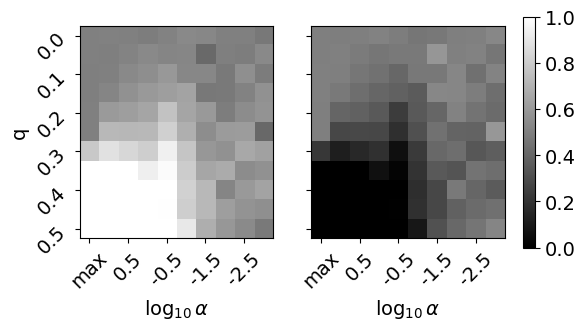

In [23]:
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))

nR = 2
datas = []
for idx_r in range(nR):
    fracs = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas[::-1])):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            fracs[idx, jdx] = np.mean([get_frac_top(i, idx_r+1) for i in data])
    datas.append(fracs.T)

fig, axes = plt.subplots(1, nR, figsize=(3*nR, 3), sharex=True, sharey=True)
for idx, ax in enumerate(axes):
    im = ax.imshow(datas[idx], cmap="gray", vmin=0, vmax=1)
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-2], rotation=45)
    if(idx==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.savefig(f"figs/supp/q_frac_2.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

10it [00:02,  3.92it/s]
10it [00:02,  4.09it/s]


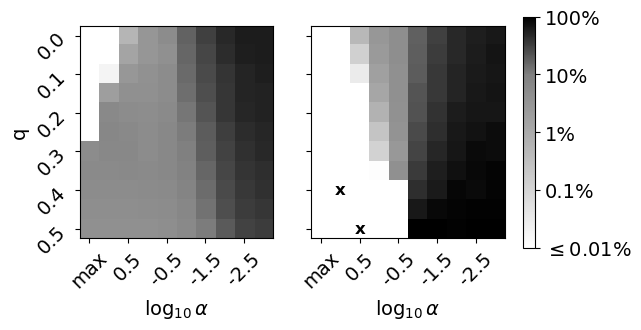

In [24]:
nR = 2
fig, axes = plt.subplots(1, nR, figsize=(nR*3, 3), sharex=True, sharey=True)
for idx_res in range(nR):
    res = idx_res+1
    avr_log_phis = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas[::-1])):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi_pref(sample, res))
            if(np.mean([get_frac_top(i, res) for i in data]) > 0):
                elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(nR)
                # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
            else:
                elem=-6
            avr_log_phis[idx, jdx] = elem

    data = avr_log_phis.T
    norm = mcolors.Normalize(vmin=-4, vmax=0)
    ax = axes[idx_res]
    im = ax.imshow(data, cmap=cmap_gray, norm=norm)
    ax.set_xlabel("$\\log_{10}\\alpha$")
    ax.set_xticks(range(len(alphas))[::2], (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-2], rotation=45)
    if(idx_res==0):
        ax.set_ylabel("q")
        ax.set_yticks(range(len(qs))[::2], [round(i, 2) for i in qs][::2], rotation=45)
    for (i, j), val in np.ndenumerate(data):
        if val == -6:
            ax.text(j, i, "x",
                    ha="center", va="center",
                    color="k",     # choose a contrasting color
                    fontsize=12,
                    fontweight="bold")
cbar = fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_ticks([0, -1, -2, -3, -4])
cbar.set_ticklabels(["100%", "10%", "1%", "0.1%", "$\\leq$0.01%"])
plt.savefig(f"figs/supp/q_hist_2.pdf", bbox_inches="tight")
plt.show()

#### misc check

0it [00:00, ?it/s]

10it [00:01,  5.88it/s]
10it [00:02,  4.75it/s]
10it [00:02,  3.35it/s]


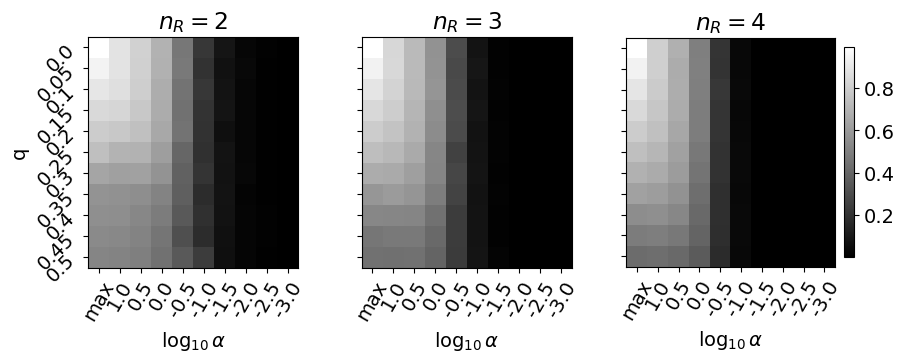

In [31]:
# the primary and secondary temporal niches
# fraction of primary/secondary temporal niches

nRs = [2, 3, 4]

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

for indx, nR in enumerate(nRs):
    alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
    tau0, p, D= 0.3, 0.5, 100.0
    qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
    all_dep_times = np.zeros([len(alphas), len(qs)])
    all_first_niches = np.zeros([len(alphas), len(qs)])
    all_delta_deps = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            dep_times = []
            first_niches = []
            for i in data:
                dep_times.append(i[1]["ts"][-2])
                first_niches.append (i[1]["ts"][1])
            all_dep_times[idx, jdx] = np.mean(dep_times)
            all_first_niches[idx, jdx] = np.mean(first_niches) / np.mean(dep_times)
            all_delta_deps[idx, jdx] = 1 - all_first_niches[idx, jdx]
    data = all_first_niches.T

    im = axes[indx].imshow(data, cmap="gray")
    axes[indx].set_xlabel("$\\log_{10}\\alpha$")
    axes[indx].set_xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=60)
    axes[indx].set_yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
    axes[indx].set_title(f"$n_R={nR}$")

axes[0].set_ylabel("q")
cbar = fig.colorbar(im, ax=axes[-1], fraction=0.046, pad=0.04)
plt.savefig("figs/supp/figS_time_frac.pdf", bbox_inches="tight")
plt.show()

10it [00:01,  6.10it/s]
10it [00:02,  4.46it/s]
10it [00:02,  3.35it/s]


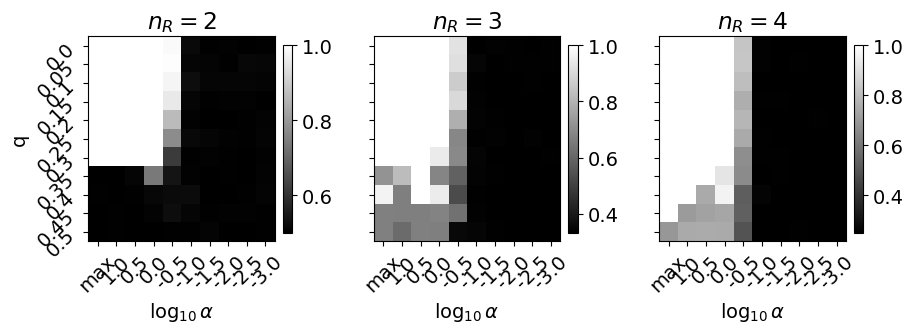

In [32]:
# try complementarity

def compl(spcs, k=0):
    nR = len(spcs[0].pref)
    choice = [i.pref[k] for i in spcs]
    abund = [i.b for i in spcs]
    return len(set(choice))/nR


nRs = [2, 3, 4]

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

for indx, nR in enumerate(nRs):
    alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
    tau0, p, D= 0.3, 0.5, 100.0
    qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
    all_comps = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            if(nR==2): label=1
            else: label=2
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_{label}.pkl", "rb"))
            comps = []
            for i in data:
                comps.append(compl(i[0], k=0))
            # print(idx, jdx, comps)
            all_comps[idx, jdx] = np.mean(comps)
    data = all_comps.T

    im = axes[indx].imshow(data, cmap="gray", vmax=1.0, vmin=1/nR)
    axes[indx].set_xlabel("$\\log_{10}\\alpha$")
    axes[indx].set_xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
    axes[indx].set_yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
    axes[indx].set_title(f"$n_R={nR}$")

    cbar = fig.colorbar(im, ax=axes[indx], fraction=0.046, pad=0.04)
axes[0].set_ylabel("q")
plt.subplots_adjust(wspace=0.4)
plt.savefig("figs/supp/figS_compl.pdf", bbox_inches="tight")
plt.show()

#### q>0 gives stable diauxers

In [6]:
a = [1,2,3]
a[::(-1)**3]

[3, 2, 1]

In [19]:
# for given phi, as fluc gets higher, second niche gets longer
# for given fluc, as phi gets higher, second niche gets shorter
Rfracs = list(10**np.linspace(-3, 0, 10))
philist = [1e-200] + list(10**np.linspace(-3, 0, 10))

def make_toy_community(phi, Rfrac, g11=0.8, pfrac=0.5, q=0.0, tau0=0.3, gC=1.0, Ncycles=100, D=200, T_dilute=24):
    # always consider only 2 resources
    bs = []
    for res in range(2):
        gi = np.array([g11*pfrac*(1-q)**i for i in range(2)])
        gi[res] = gi[res]/pfrac
        bs.append(LeakySeqUt(phi=phi, g_enz=gi, gC=gC, pref_list=get_smart_pref(gi), 
                        tau0=tau0, biomass=0.01, id=f"{phi}_{res}"))
    for species in bs:
        species.RezeroLag()
    C = EcoSystem(bs)
    # b_list, id_list = [], []
    last_cycles = []
    for i in range(Ncycles):
        Rs = (np.array([Rfrac, 1])*2/(1+Rfrac))[::(-1)**i]
        C.OneCycle(Rs, T_dilute)
        C.MoveToNext(D)
        # b_list.append(C.last_cycle['bs'][-1])
        # id_list.append(C.last_cycle['ids'])
        last_cycles.append(C.last_cycle)
    return last_cycles[-2:]

def get_2_niches(cycle):
    cs, ts = cycle["cs"], cycle["ts"]
    for idx, arr in enumerate(cs):
        if((arr==0).any()):
            idx_0 = idx
            break
    idx_1=idx_0 # if resources depleted at the same time
    for idx, arr in enumerate(cs):
        if(np.sum(arr==0)==2):
            idx_1 = idx
            break
    return ts[idx_0], ts[idx_1]-ts[idx_0]

results_1 = np.zeros([len(philist), len(Rfracs)])
results_2 = np.zeros([len(philist), len(Rfracs)])
for idx, phi in tqdm(enumerate(philist)):
    for jdx, Rfrac in enumerate(Rfracs):
        last_cycles = make_toy_community(phi, Rfrac)
        x1, x2 = get_2_niches(last_cycles[0])
        x3, x4 = get_2_niches(last_cycles[1])
        results_1[idx, jdx] = (x1+x3)/2
        results_2[idx, jdx] = (x2+x4)/2

11it [00:06,  1.59it/s]


In [25]:
results_1

array([[0.2278957 , 0.44785465, 0.82078099, 1.37320286, 2.08658897,
        2.91284659, 3.8050282 , 4.73140842, 5.67398183, 6.62289671],
       [0.24720921, 0.48444631, 0.8840183 , 1.4707065 , 2.22011142,
        3.07465499, 3.97093706, 4.84632119, 5.67564101, 6.62455285],
       [0.24863166, 0.48715323, 0.88874575, 1.47817173, 2.230869  ,
        3.08913838, 3.98953262, 4.86930314, 5.67755756, 6.62646578],
       [0.25028851, 0.49030192, 0.89423302, 1.48681164, 2.24327402,
        3.10576606, 4.01077125, 4.89540465, 5.69076235, 6.63059083],
       [0.25236427, 0.49423876, 0.90107236, 1.49753477, 2.25858835,
        3.12616088, 4.03662416, 4.92691428, 5.72771473, 6.63949545],
       [0.25525832, 0.49971279, 0.91054268, 1.51229977, 2.27952834,
        3.15381134, 4.07132322, 4.96873897, 5.77623064, 6.65876137],
       [0.25985759, 0.50838437, 0.92547169, 1.53542481, 2.31206553,
        3.19636686, 4.12412611, 5.03158922, 5.8482247 , 6.70065087],
       [0.26821783, 0.5240887 , 0.9523589

In [24]:
results_2

array([[12.79000202, 12.35008413, 11.60423144, 10.49938769,  9.07261548,
         7.42010024,  5.63573701,  3.78297658,  1.89782976,  0.        ],
       [ 9.26118934,  8.94495228,  8.41232282,  7.63026745,  6.6313107 ,
         5.49220412,  4.29746012,  3.13057307,  1.89749926,  0.        ],
       [ 9.18275159,  8.86489412,  8.32972582,  7.54424782,  6.54119199,
         5.39744919,  4.19757014,  3.02517459,  1.8971176 ,  0.        ],
       [ 9.10424745,  8.78460091,  8.24665108,  7.45746308,  6.45001698,
         5.30136204,  4.09608867,  2.91794617,  1.8586998 ,  0.        ],
       [ 9.02571871,  8.70402563,  8.16293695,  7.36964195,  6.35744068,
         5.20356922,  3.99265306,  2.8085672 ,  1.7435026 ,  0.        ],
       [ 8.94726266,  8.62307891,  8.07825608,  7.28023478,  6.26277317,
         5.10334112,  3.886581  ,  2.69647142,  1.62561482,  0.        ],
       [ 8.86909503,  8.54157119,  7.99190792,  7.18807427,  6.16456946,
         4.9991829 ,  3.77652481,  2.58061424

#### confirming some calculations for periodic env


In [5]:
from scipy.special import beta, betainc

def rRandom(alpha, cycle):
    zero_thr = 1e-8
    if(alpha==0):
        result = choice([np.array([1.0, 0.0]), np.array([0.0, 1.0])])
    elif(alpha=="max"):
        return np.array([0.5, 0.5])
    else:
        result = np.random.dirichlet([alpha, alpha])
        if(np.isnan(result).any() or np.isinf(result).any()):
            result = choice([np.array([1.0, 0.0]), np.array([0.0, 1.0])])
    if(0 in result):
        result = (1-len(result)*zero_thr)*result+zero_thr
    return result
        
def minExpectation(alpha): # expectation of min(R1, R2) for dirichlet(alpha, alpha)
    if(alpha=="max"):
        return 0.5
    elif(alpha==0):
        return 0.0
    else:
        integral = betainc(alpha+1, alpha, 0.5)
        return 2 * integral * beta(alpha+1, alpha) / beta(alpha, alpha)
def rProtocol(alpha, cycle):
    zero_thr = 1e-8
    k = 1 # expectation of len(continuous steps of R1>R2) = k
    x1 = minExpectation(alpha)
    Rlist = [np.array([x1, 1-x1]) for i in range(k)] + [np.array([1-x1, x1]) for i in range(k)]
    result = Rlist[ cycle%len(Rlist) ]
    if(0 in result):
        result = (1-len(result)*zero_thr)*result+zero_thr
    return result

def get_seq_vs_spec_growth(params, phi):
    a, q, p, tau0, D, g11 = params
    R1 = minExpectation(a)
    R2 = 1-R1
    gamma1 = (R2+D*R1)/(R1+D*R2)*D
    gamma2 = D**2/gamma1
    g12, g21, g22 = g11*p*(1-q), g11*p, g11*(1-q)
    # print("g11, g12, g21, g22:", g11, g12, g21, g22)
    T11 = np.log(gamma1)/g11
    T12 = np.log(gamma2)/g22
    T21 = np.log(gamma1)/g22
    T22 = np.log(gamma2)/g11
    disc0 = T22 - T21
    disc1 = T12 - T11 - tau0*np.log(1/phi)
    if(disc0>=0):
        disc2 = g11*(T22 - T21 - tau0*np.log(1/(1-phi)))
    else:
        disc2 = g12*(T21 - T22 - tau0*np.log(1/phi))
    growth = ((1-phi)*g11+phi*g12)*T11 \
            + g12*disc1*(disc1>0) \
            + ((1-phi)*g11+phi*g12)*min(T22, T21) \
            + disc2*(disc2>0) \
            - 2*np.log(D)
    # print((1-phi)*g11+phi*g12)
    # print("ts:", T11, T12, T21, T22)
    # print("disc:", disc1, disc2)
    return growth, disc0, disc1, disc2




def get_seq_vs_spec_growth_1(params, phi):
    a, q, p, tau0, D, g11 = params
    R1 = minExpectation(a)
    R2 = 1-R1
    gamma1 = (R2+D*R1)/(R1+D*R2)*D
    gamma2 = D**2/gamma1
    g12, g21, g22 = g11*p*(1-q), g11*p, g11*(1-q)
    # print("g11, g12, g21, g22:", g11, g12, g21, g22)
    T11 = np.log(gamma1)/g11
    T12 = np.log(gamma2)/g22
    T21 = np.log(gamma1)/g22
    T22 = np.log(gamma2)/g11
    disc0 = T22 - T21
    disc1 = T12 - T11 - tau0*np.log(1/(1-phi))
    if(disc0>=0):
        disc2 = g21*(T22 - T21 - tau0*np.log(1/phi))
    else:
        disc2 = g22*(T21 - T22 - tau0*np.log(1/(1-phi)))
    growth = ((1-phi)*g22+phi*g21)*T11 \
            + g22*disc1*(disc1>0) \
            + ((1-phi)*g22+phi*g21)*min(T22, T21) \
            + disc2*(disc2>0) \
            - 2*np.log(D)
    # print((1-phi)*g11+phi*g12)
    # print("ts:", T11, T12, T21, T22)
    # print("disc:", disc1, disc2)
    return growth, disc0, disc1, disc2

/tmp/ipykernel_3728495/1132072594.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(base_colors)


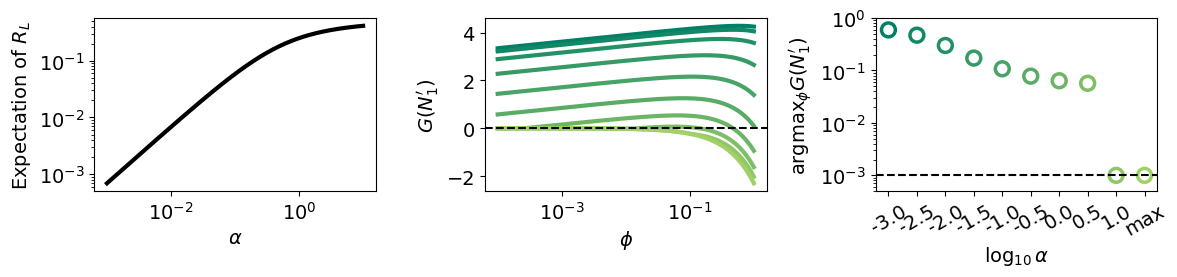

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

alpha_list = 10**np.linspace(-3, 1, 900)
RL_list = [minExpectation(a) for a in alpha_list]
axes[0].plot(alpha_list, RL_list, color='k', linewidth=3)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_ylabel("Expectation of $R_L$")

q = 0.0
p = 0.5
tau0 = 0.3
D = 100
g11 = 0.8
phis = 10**np.linspace(log10(1e-4/2), log10(0.5), 1000)
import matplotlib.cm as cm 
def get_shade_color(idx, n, base_colors="summer"):
    norm_idx = idx/n*0.7
    cmap = cm.get_cmap(base_colors) 
    return cmap(norm_idx)

maxs = []
alist = 10**np.linspace(-3, 1, 9)
for idx, a in enumerate((list(alist) + ["max"])):
    params = [a, q, p, tau0, D, g11]
    growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
    discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
    axes[1].plot(phis/0.5, growth, 
             color=get_shade_color(idx, 10), 
             label=f"{(list(np.log10(alist)) + ["max"])[idx]}", 
             linewidth=3)
    maxs.append(phis[growth.index(max(growth))]/0.5)

axes[1].axhline(0, color='k', linestyle='--')
axes[1].set_xscale("log")
# axes[1].legend(title="Effective $\\alpha$", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xlabel("$\\phi$")
axes[1].set_ylabel("$G(N_1')$")

for idx, a in enumerate((list(alist) + ["max"])):
    axes[2].scatter(idx, max(maxs[idx], 1e-3), marker='o', s=100,
                    facecolors="none", 
                    edgecolors=get_shade_color(idx, 10), 
                    linewidths=2.5)
axes[2].set_yscale("log")
axes[2].set_xticks(range(len(alist)+1)[::-1], (list(np.log10(alist)) + ["max"])[::-1], 
                 rotation=30)
axes[2].axhline(1e-3, color="k", linestyle="--")
axes[2].set_ylim(1e-3 / 2, 1)
axes[2].set_xlabel("$\\log_{10}\\alpha$")
axes[2].set_ylabel("argmax$_\\phi G(N_1')$")
plt.tight_layout()
plt.savefig("figs/supp/phase_transition.pdf", bbox_inches='tight')

/tmp/ipykernel_3728495/1132072594.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(base_colors)


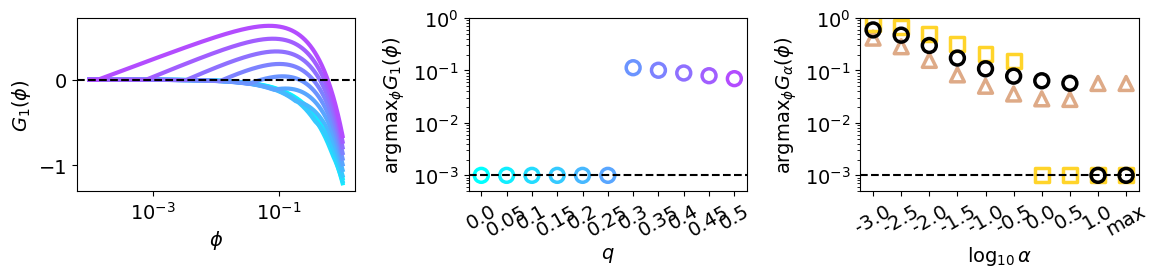

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
maxs = []
qs =  list(np.round(np.linspace(0.0, 0.5, 11), 2))
a = 'max'
for idx, q in enumerate(qs):
    params = [a, q, p, tau0, 10, g11]
    growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
    discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
    axes[0].plot(phis/0.5, growth, 
             color=get_shade_color(idx, 10, 'cool'), 
             linewidth=3)
    maxs.append(phis[growth.index(max(growth))]/0.5)

axes[0].axhline(0, color='k', linestyle='--')
axes[0].set_xscale("log")
# axes[1].legend(title="Effective $\\alpha$", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xlabel("$\\phi$")
axes[0].set_ylabel("$G_1(\\phi)$")

for idx, q in enumerate(qs):
    axes[1].scatter(idx, max(maxs[idx], 1e-3), marker='o', s=100,
                    facecolors="none", 
                    edgecolors=get_shade_color(idx, 10, 'cool'), 
                    linewidths=2.5)
axes[1].set_yscale("log")
axes[1].set_xticks(range(len(qs)), qs, 
                 rotation=30)
axes[1].axhline(1e-3, color="k", linestyle="--")
axes[1].set_ylim(1e-3 / 2, 1)
axes[1].set_xlabel("$q$")
axes[1].set_ylabel("argmax$_\\phi G_1(\\phi)$")

maxs = []
alist = 10**np.linspace(-3, 1, 9)
    
q = 0.3
for idx, a in enumerate((list(alist) + ["max"])[::-1]):
    params = [a, q, p, tau0, D, g11]
    growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
    discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
    maxs.append(phis[growth.index(max(growth))]/0.5)
for idx, a in enumerate(list(alist) + ["max"]):
    axes[2].scatter(idx, max(maxs[::-1][idx], 1e-3), marker='^', s=100,
                    facecolors="none", 
                    edgecolors=brown, 
                    linewidths=2.5)
    
q = 0.3
for idx, a in enumerate((list(alist) + ["max"])[::-1]):
    params = [a, q, p, tau0, D, g11]
    growth = [get_seq_vs_spec_growth_1(params, phi)[0] for phi in phis]
    maxs.append(phis[growth.index(max(growth))]/0.5)
for idx, a in enumerate(list(alist) + ["max"]):
    axes[2].scatter(idx, max(maxs[::-1][idx], 1e-3), marker='s', s=100,
                    facecolors="none", 
                    edgecolors=yellow, 
                    linewidths=2.5)
    
q = 0
for idx, a in enumerate((list(alist) + ["max"])[::-1]):
    params = [a, q, p, tau0, D, g11]
    growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
    discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
    maxs.append(phis[growth.index(max(growth))]/0.5)
for idx, a in enumerate(list(alist) + ["max"]):
    axes[2].scatter(idx, max(maxs[::-1][idx], 1e-3), marker='o', s=100,
                    facecolors="none", 
                    edgecolors='k', 
                    linewidths=2.5)
    
axes[2].set_yscale("log")
axes[2].set_xticks(range(len(alist)+1)[::-1], (list(np.log10(alist)) + ["max"])[::-1], 
                 rotation=30)
axes[2].axhline(1e-3, color="k", linestyle="--")
axes[2].set_ylim(1e-3 / 2, 1)
axes[2].set_xlabel("$\\log_{10}\\alpha$")
axes[2].set_ylabel("argmax$_\\phi G_\\alpha(\\phi)$")
plt.tight_layout()
plt.savefig("figs/supp/intro_q_1.pdf", bbox_inches='tight')
plt.show()

10it [00:02,  3.82it/s]


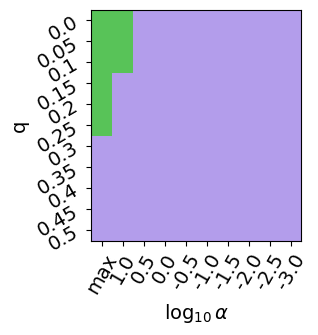

In [17]:
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
tau0, p, D= 0.3, 0.5, 10.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
g11 = 0.8
outputs = np.zeros([len(alphas), len(qs)])
phis = 10**np.linspace(log10(1e-4/2), log10(0.5), 1000)

for idx, a in tqdm(enumerate(alphas)):
    for jdx, q in enumerate(qs):
        params = [a, q, p, tau0, D, g11]
        growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
        discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
        maxphi = phis[growth.index(max(growth))]/0.5
        if(maxphi>1e-3):
            outputs[idx, jdx] = 1

color_for_zero = soft_green
color_for_one = soft_purple
cmap_2 = mcolors.ListedColormap([color_for_zero, color_for_one])

data = outputs.T
fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(data, cmap=cmap_2)
plt.xlabel("$\\log_{10}\\alpha$")
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=60)
plt.ylabel("q")
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=30)
plt.savefig("figs/supp/intro_q_2.pdf", bbox_inches='tight')
plt.show()

In [5]:
def get_best_phi(params):
    global b_list, id_list, phi_list
    b_list, id_list, phi_list = [], [], []
    a, q, p, tau0, D, g11 = params
    T_dilute = 24
    g1 = np.array([g11, p*(1-q)*g11])
    g2 = np.array([(1-q)*g11, p*g11])
    phis = [MIN_PHI] + list(10**np.linspace(-4, np.log10(0.5), 30))
    spc_groups = []
    for phi in phis:
        b1 = LeakySeqUt(phi=phi, g_enz=g1, gC=1.0, pref_list=get_smart_pref(g1), tau0=tau0, biomass=0.01, id=f"{phi}")
        b2 = LeakySeqUt(phi=phi, g_enz=g2, gC=1.0, pref_list=get_smart_pref(g2), tau0=tau0, biomass=0.01, id=f"{phi}")
        b1.RezeroLag()
        b2.RezeroLag()
        spc_groups.append([b1, b2])
    random.shuffle(spc_groups)
    C = EcoSystem(spc_groups[0])
    for i in range(20):
        Rs = rProtocol(a, i)
        C.OneCycle(Rs, T_dilute)
        b_list.append(C.last_cycle['bs'][-1])
        id_list.append(C.last_cycle['ids'])
        phi_list.append([i.phi for i in C.species if i.id in C.last_cycle['ids']])
        C.MoveToNext(D)
    
    cycle = 0
    for pair in tqdm(spc_groups[1:] + spc_groups):
        if(pair[0].phi not in [i.phi for i in C.species]):
            C.Invade(pair[0])
            C.Invade(pair[1])
            pair[0].b, pair[1].b = 1e-7, 1e-7
            while(len(set([i.phi for i in C.species]))>1):
                Rs = rProtocol(a, cycle)
                C.OneCycle(Rs, T_dilute)
                b_list.append(C.last_cycle['bs'][-1])
                id_list.append(C.last_cycle['ids'])
                phi_list.append([i.phi for i in C.species if i.id in C.last_cycle['ids']])
                C.MoveToNext(D)
                cycle += 1
                if(cycle%5000==0):
                    print(cycle)
                    print(C.last_cycle)

    return C

In [6]:
q = 0.0
p = 0.5
tau0 = 0.5
D = 100
g11 = 0.8
a = 10**0.0
params = [a, q, p, tau0, D, g11]
C_end = get_best_phi(params)
print([i.phi for i in C_end.species])

100%|██████████| 61/61 [00:02<00:00, 26.17it/s]

[0.20716573966075624, 0.20716573966075624]


/tmp/ipykernel_3148710/913626397.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(base_colors)


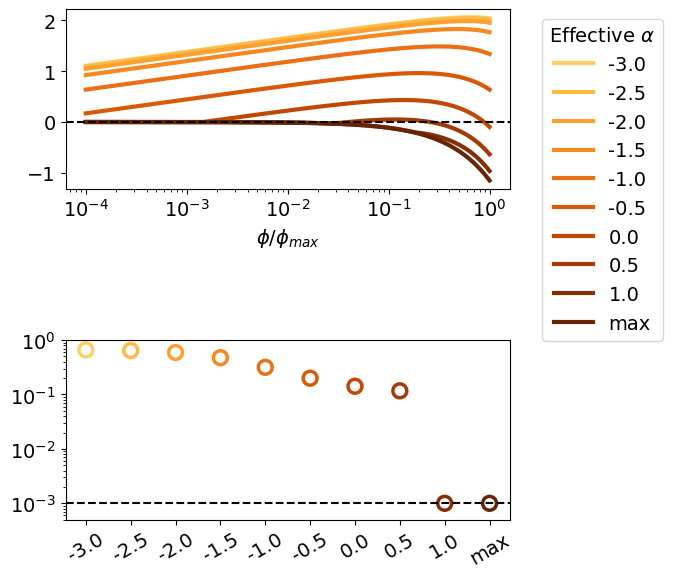

In [29]:
from scipy.special import beta, betainc
def minExpectation(alpha): # expectation of min(R1, R2) for dirichlet(alpha, alpha)
    if(alpha=="max"):
        return 0.5
    elif(alpha==0):
        return 0.0
    else:
        integral = betainc(alpha+1, alpha, 0.5)
        return 2 * integral * beta(alpha+1, alpha) / beta(alpha, alpha)

def get_seq_vs_spec_growth(params, phi):
    a, q, p, tau0, D, g11 = params
    R1 = minExpectation(a)
    R2 = 1-R1
    gamma1 = (R2+D*R1)/(R1+D*R2)*D
    gamma2 = D**2/gamma1
    g12, g21, g22 = g11*p*(1-q), g11*p, g11*(1-q)
    # print("g11, g12, g21, g22:", g11, g12, g21, g22)
    T11 = np.log(gamma1)/g11
    T12 = np.log(gamma2)/g22
    T21 = np.log(gamma1)/g22
    T22 = np.log(gamma2)/g11
    disc0 = T22 - T21
    disc1 = T12 - T11 - tau0*np.log(1/phi)
    if(disc0>=0):
        disc2 = g11*(T22 - T21 - tau0*np.log(1/(1-phi)))
    else:
        disc2 = g12*(T21 - T22 - tau0*np.log(1/phi))
    growth = ((1-phi)*g11+phi*g12)*T11 \
            + g12*disc1*(disc1>0) \
            + ((1-phi)*g11+phi*g12)*min(T22, T21) \
            + disc2*(disc2>0) \
            - 2*np.log(D)
    # print((1-phi)*g11+phi*g12)
    # print("ts:", T11, T12, T21, T22)
    # print("disc:", disc1, disc2)
    return growth, disc0, disc1, disc2

import matplotlib.cm as cm 
def get_shade_color(idx, n, base_colors="YlOrBr"):
    norm_idx = idx/(n-1)*2/3 + 0.33
    cmap = cm.get_cmap(base_colors) 
    return cmap(norm_idx)

q = 0.0
p = 0.5
tau0 = 0.3
D = 10
g11 = 0.8
# a = 10.0
# params = [a, q, p, tau0, D, g11]
# print(get_seq_vs_spec_growth(params, 0.01))

phis = 10**np.linspace(log10(1e-4/2), log10(0.5), 1000)
alist = 10**np.linspace(-3, 1, 9)
maxs = []
fig, axes = plt.subplots(2, 1, figsize=(7, 6))
for idx, a in enumerate(list(alist) + ["max"]):
    params = [a, q, p, tau0, D, g11]
    growth = [get_seq_vs_spec_growth(params, phi)[0] for phi in phis]
    discs = [get_seq_vs_spec_growth(params, phi)[1] for phi in phis]
    axes[0].plot(phis/0.5, growth, 
             color=get_shade_color(idx, 10), 
             label=f"{(list(np.log10(alist)) + ["max"])[idx]}", 
             linewidth=3)
    maxs.append(phis[growth.index(max(growth))]/0.5)

axes[0].axhline(0, color='k', linestyle='--')
axes[0].set_xscale("log")
axes[0].legend(title="Effective $\\alpha$", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xlabel("$\\phi/\\phi_{max}$")
# axes[0].set_ylabel("log net growth\n invading 2 specialists")

for idx, a in enumerate(list(alist) + ["max"]):
    axes[1].scatter(idx, max(maxs[idx], 1e-3), marker='o', s=100,
                    facecolors="none", 
                    edgecolors=get_shade_color(idx, 10), 
                    linewidths=2.5)
axes[1].set_yscale("log")
axes[1].set_xticks(range(len(alist)+1), (list(np.log10(alist)) + ["max"]), 
                   rotation=30)
axes[1].axhline(1e-3, color="k", linestyle="--")
axes[1].set_ylim(1e-3 / 2, 1)
plt.tight_layout()

In [ ]:
def get_seq_vs_spec_growth(params, phi):
    a, q, p, tau0, D, g11 = params
    R1 = minExpectation(a)
    R2 = 1-R1
    gamma1 = (R2+D*R1)/(R1+D*R2)*D
    gamma2 = D**2/gamma1
    g12, g21, g22 = g11*p, g11*p*(1-q), g11*(1-q)
    T11 = np.log(gamma1)/g11
    T12 = np.log(gamma2)/g22
    T21 = np.log(gamma1)/g22
    T22 = np.log(gamma2)/g11
    print(T11, T12, T21, T22)
    disc1 = T12 - T11 - tau0*np.log(1/phi)
    disc2 = T22 - T21 - tau0*np.log(1/(1-phi))
    growth = ((1-phi)*g11+phi*g12)*T11 \
            + g12*disc1*(disc1>0) \
            + ((1-phi)*g11+phi*g12)*T21 \
            + g11*disc2*(disc2>0) \
            - 2*np.log(D)
    return growth, disc1, disc2

q = 0.2
p = 0.3
tau0 = 0.6
D = 100
g11 = 0.8
a = 10**0.0
params = [a, q, p, tau0, D, g11]
get_seq_vs_spec_growth(params, 1e-2)

4.415986136836064 8.871174160167703 5.519982671045079 7.096939328134164


(0.34563503228349113, 1.6920859117387845, 1.5709264555769844)

In [ ]:
alphas = list(10**np.linspace(-3, 1, 9))
tau0, p, D= 0.6, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2

avr_log_phis = np.zeros([len(alphas), len(qs)])
for idx, a in tqdm(enumerate(alphas)):
    for jdx, q in enumerate(qs):
        data = pickle.load(open(f"data/with_leaky/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_seasonal_nR={nR}_1.pkl", "rb"))
        all_pairs = []
        for sample in data:
            all_pairs.extend(get_phi(sample, "seq"))
            all_pairs.extend(get_phi(sample, "spec"))
        elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(nR)
        # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
        surv_list = []
        for sample in data:
            surv_list.extend(sample[0])
        avr_log_phis[idx, jdx] = elem

data = avr_log_phis.T
norm = mcolors.Normalize(vmin=-4, vmax=0)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data, cmap=cmap_gray, norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.xlabel("$\\log_{10}\\alpha$")
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))), rotation=45)
plt.ylabel("q")
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
# plt.savefig("figs/vers2/fig2_2spc_phi.pdf", bbox_inches="tight")
plt.show()

2it [00:01,  1.62it/s]


NameError: name 'MIN_RHO' is not defined

In [ ]:
logalphas = np.linspace(-0.5, 1.5, 41)
qgrids = np.linspace(0, 0.5, 51)
best_qs = []
for logalpha in tqdm(logalphas):
    for q in qgrids:
        params = [10**logalpha, q, p, tau0, D, g11]
        growth = [get_seq_vs_spec_growth(params, phi/2)[0] for phi in phis]
        if(max(growth)>0):
            best_qs.append(q)
            break

100%|██████████| 41/41 [00:05<00:00,  6.93it/s]


In [ ]:
g11, p, q = 0.8, 0.5, 0.0
D = 100
tau0 = 0.3
params = [g11, p, q, a, D, tau0]
nR = 2

def get_cout_delta_growth(params, phi, phi1):
    '''
    params: g11, p, q, a, D, tau0
    phi: float, the current phi
    phi1: float, the next phi
    '''
    g11, p, q, a, D, tau0 = params
    g12 = p*g11
    b0 = 1/(D-1)
    k = phi/(1-phi)
    R1 = minExpectation(a)
    R2 = 1-R1
    gamma1 = 1 + (1/b0)*R1*(1+k*g12/g11)
    gamma2 = 1 + (1/b0/gamma1)*(R2-(k*g12/g11)*R1)
    gamma3 = 1 + (1/b0)*R1*(1+k*g11/g12)
    gamma4 = 1 + (1/b0/gamma3)*(R2-(k*g11/g12)*R1)
    T11 = np.log(gamma1)/(g11*(1-phi)+g12*phi)
    T12 = np.log(gamma2)/(g12) + tau0*np.log(1/phi)
    T21 = np.log(gamma3)/(g11*(1-phi)+g12*phi)
    T22 = np.log(gamma4)/(g11) + tau0*np.log(1/(1-phi))
    overgrowth = ((1-phi1)*g11+phi1*g12)*T11 \
                + g12*(T12 - tau0*np.log(1/phi1)) \
                + ((1-phi1)*g11+phi1*g12)*T21 \
                + g11*(T22 - tau0*np.log(1/(1-phi1))) \
                - 2*np.log(D)
    return overgrowth

phis = 10**np.linspace(-2, 0, 1000)/nR
delta_logphi = 0.001
alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
phi_opts = []
for a in alphas:
    growths = []
    for phi in phis:
        phi1 = 10**(np.log10(phi) + delta_logphi)
        params = [g11, p, q, a, D, tau0]
        growth = get_cout_delta_growth(params, phi, phi1)
        growths.append(growth)
    plt.plot(2*phis, growths, label=f"$\\alpha$={a}")
    idx = np.argmin(np.abs(np.array(growths)))
    phi_opts.append(2*phis[idx])
plt.axhline(0, color='k', linestyle='--')
plt.xscale("log")
plt.legend()
plt.show()

plt.plot(alphas, phi_opts, 'o')
plt.xscale("log")


In [ ]:
a = np.array([0.4, 0.3, 0.8, 0.3])
np.argsort(a)[::-1]+1

array([3, 1, 4, 2])